# Practical Session on Graph Neural Networks

**by Matthieu Nastorg and Cyriaque Rousselot**

## **PART 1 : CODING** (8/20)

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [1]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/
#####################################################
import torch


def format_pytorch_version(version):
    return version.split("+")[0]


TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)


def format_cuda_version(version):
    return "cu" + version.replace(".", "")


CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-2.2.0+cu121.html

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Looking in links: https://pytorch-geometric.com/whl/torch-2.2.0+cu121.html

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Looking in links: https://pytorch-geometric.com/whl/torch-2.2.0+cu121.html

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Looking in links: https://pytorch-geometric.com/whl/torch-2.2.0+cu121.html

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it : 

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

In [2]:
#####################################################
################## PACKAGES #########################
#####################################################
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training 
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node:
- 50 features : positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct node's labels**.

**It is a node (multi-level) classification task** (trained using supervised learning). 

For your curiosity, more details information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


In [3]:
### LOAD DATASETS

BATCH_SIZE = 2

# Train Dataset
train_dataset = PPI(root="", split="train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split="val")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split="test")
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]
"""
From PyG documentation: 
A single graph in PyG is described by an instance of torch_geometric.data.Data, which holds the following attributes by default:
data.x: Node feature matrix with shape [num_nodes, num_node_features]
data.edge_index: Graph connectivity in COO format with shape [2, num_edges] and type torch.long
data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]
data.y: Target to train against (may have arbitrary shape), e.g., node-level targets of shape 
[num_nodes, *] or graph-level targets of shape [1, *]
data.pos: Node position matrix with shape [num_nodes, num_dimensions]
"""

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Target to train against shape:",train_dataset[0].y.shape)
print("Target to train against:",train_dataset[0].y)
print("Target to train against for first node:",train_dataset[0].y[0])
# goal is to predict node labels, which are k-hot encoded, this is multi-label classification
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Target to train against shape: torch.Size([1767, 121])
Target to train against: tensor([[1., 0., 0.,  ..., 1., 1., 0.],
        [1., 0., 0.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])
Target to train against for first node: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 

### Define a basic Model

Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-level) classification task, computing 121 features.

In [4]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()
        # smooth ReLU but taking values in (-1,+infty)

    def forward(self, x, edge_index):
        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)

        return x

Next we construct the function to train the model.

In [5]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(
    model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader
):

    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

Next function is designed to evaluate the performance of the model, computing the F1-Score

In [6]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):
    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        # If the element of output is greater than or equal to 0, it replaces it with 1.
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

If the element of output is greater than or equal to 0, it replaces it with 1, otherwise 0. Thus, we would want an output layer activation function with values in (-1,1).

Let's train this model !

In [7]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

### DEFINE THE MODEL
basic_model = BasicGraphModel(
    input_size=n_features, hidden_size=256, output_size=n_classes
).to(device)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train(
    basic_model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_dataloader,
    val_dataloader,
)


Device:  cuda


Epoch 00001 | Loss: 0.6370
F1-Score: 0.4506
Epoch 00002 | Loss: 0.5793
Epoch 00003 | Loss: 0.5611
Epoch 00004 | Loss: 0.5552
Epoch 00005 | Loss: 0.5500
Epoch 00006 | Loss: 0.5458
F1-Score: 0.5169
Epoch 00007 | Loss: 0.5423
Epoch 00008 | Loss: 0.5382
Epoch 00009 | Loss: 0.5342
Epoch 00010 | Loss: 0.5311
Epoch 00011 | Loss: 0.5282
F1-Score: 0.5146
Epoch 00012 | Loss: 0.5256
Epoch 00013 | Loss: 0.5232
Epoch 00014 | Loss: 0.5209
Epoch 00015 | Loss: 0.5186
Epoch 00016 | Loss: 0.5164
F1-Score: 0.5352
Epoch 00017 | Loss: 0.5141
Epoch 00018 | Loss: 0.5120
Epoch 00019 | Loss: 0.5098
Epoch 00020 | Loss: 0.5078
Epoch 00021 | Loss: 0.5057
F1-Score: 0.5478
Epoch 00022 | Loss: 0.5037
Epoch 00023 | Loss: 0.5018
Epoch 00024 | Loss: 0.4999
Epoch 00025 | Loss: 0.4982
Epoch 00026 | Loss: 0.4966
F1-Score: 0.5593
Epoch 00027 | Loss: 0.4954
Epoch 00028 | Loss: 0.4946
Epoch 00029 | Loss: 0.4941
Epoch 00030 | Loss: 0.4944
Epoch 00031 | Loss: 0.4921
F1-Score: 0.5103
Epoch 00032 | Loss: 0.4906
Epoch 00033 | Los

Let's evaluate the performance of this basic model

Basic Model : F1-Score on the test set: 0.6675


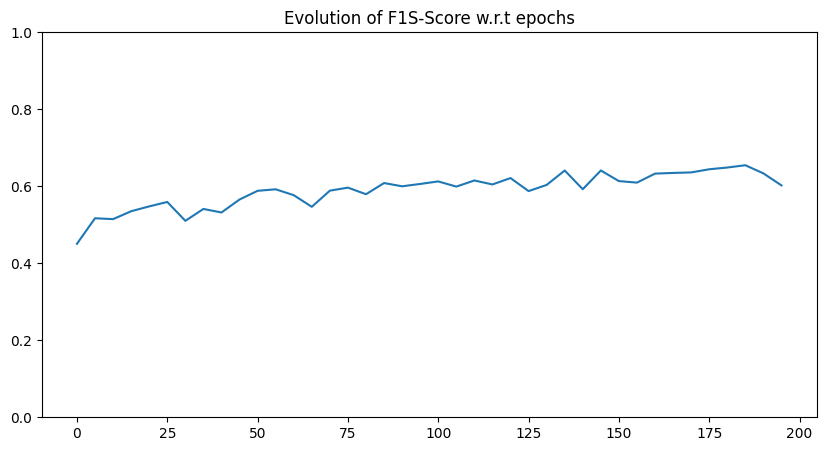

In [8]:
### F1-SCORE ON TEST DATASET
score_test = evaluate(basic_model, loss_fcn, device, test_dataloader)
print("Basic Model : F1-Score on the test set: {:.4f}".format(score_test))


### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1S-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()


plot_f1_score(epoch_list, basic_model_scores)

### Define a better model

Now, it's your turn to improve this basic model ! To do so, complete whenever ###### YOUR ANSWER ######## and run the two following cells.

**HINT :** https://arxiv.org/pdf/1710.10903.pdf

In [9]:
from torch_geometric.nn import GAT, GATv2Conv
import torch.nn.functional as F

class StudentModel(nn.Module):
  # def __init__(self, input_size, hidden_size, output_size):
  def __init__(self, num_node_features=50, nhid = 256, nout = n_classes, num_layers = 3, dropout=0.0, alpha=0.2):
        # super(GAT, self).__init__()
        super().__init__()
        self.num_layers = num_layers
        self.dropout = dropout
        self.conv1 = GATv2Conv(num_node_features, nhid, heads=4, dropout=dropout, concat=True, negative_slope=alpha)
        self.conv2 = GATv2Conv(nhid * 4, nhid, heads=4, dropout=dropout, concat=True, negative_slope=alpha)  
        self.conv3 = GATv2Conv(nhid * 4, nhid, heads=6, dropout=dropout, concat=True, negative_slope=alpha)
        # since we set concat=False on the last layer, we perform averaging over the 6 attention heads' output
        # We can see in the parameters table below we have the right output shape
        self.final_post_process = nn.Linear(nhid*6, nout)

  def forward(self, x, edge_index):
        # 1st layer
        x1 = F.elu(self.conv1(x, edge_index))
        x1 = F.dropout(x1, p=self.dropout, training=self.training)
        # 2nd layer
        x2 = F.elu(self.conv2(x1, edge_index))
        x2 = F.dropout(x2, p=self.dropout, training=self.training)
        # Apply residual connection across the second GAT layer
        # x2 += x1  # Add the output of the first layer to the output of the second layer
        # 3rd layer
        x3 = self.conv3(x2, edge_index)
        # x = F.normalize(x, p=2, dim=-1)
        # x = global_mean_pool(x, batch)
        x4 = self.final_post_process(x3)
        x4 = 2 * F.sigmoid(x4) - 1
        return x4
"""      
  def forward(self, x, edge_index):
    # x, edge_index, batch = graph_batch.x, graph_batch.edge_index, graph_batch.batch
    # 1st layer
    x = F.elu(self.conv1(x, edge_index))
    x = F.dropout(x, p=self.dropout, training=self.training)
    # 2nd layer
    x = F.elu(self.conv2(x, edge_index))
    x = F.dropout(x, p=self.dropout, training=self.training)
    # 3rd layer
    x = self.conv3(x, edge_index)
    x = 2*F.sigmoid(x)-1

    return x
      ####### YOUR ANSWER #######"""


'      \n  def forward(self, x, edge_index):\n    # x, edge_index, batch = graph_batch.x, graph_batch.edge_index, graph_batch.batch\n    # 1st layer\n    x = F.elu(self.conv1(x, edge_index))\n    x = F.dropout(x, p=self.dropout, training=self.training)\n    # 2nd layer\n    x = F.elu(self.conv2(x, edge_index))\n    x = F.dropout(x, p=self.dropout, training=self.training)\n    # 3rd layer\n    x = self.conv3(x, edge_index)\n    x = 2*F.sigmoid(x)-1\n\n    return x\n      ####### YOUR ANSWER #######'

Here we use the sigmoid (transformed to take values in (-1,1) as discussed above) activation for the output layer as is advised by https://www.geeksforgeeks.org/multiclass-classification-vs-multi-label-classification/ since it acts indepently on all labels. The softmax would act on all labels but this is not what we want since each node can belong to multiple classes.

Other code attempt from https://nn.labml.ai/graphs/gatv2/index.html that should be SOTA on the PPI dataset according to https://paperswithcode.com/sota/node-classification-on-ppi.

Let's train your model !

In [10]:
## Student model
student_model = StudentModel().to(device)

In [11]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [12]:
count_parameters(student_model)

+---------------------------+------------+
|          Modules          | Parameters |
+---------------------------+------------+
|         conv1.att         |    1024    |
|         conv1.bias        |    1024    |
|     conv1.lin_l.weight    |   51200    |
|      conv1.lin_l.bias     |    1024    |
|     conv1.lin_r.weight    |   51200    |
|      conv1.lin_r.bias     |    1024    |
|         conv2.att         |    1024    |
|         conv2.bias        |    1024    |
|     conv2.lin_l.weight    |  1048576   |
|      conv2.lin_l.bias     |    1024    |
|     conv2.lin_r.weight    |  1048576   |
|      conv2.lin_r.bias     |    1024    |
|         conv3.att         |    1536    |
|         conv3.bias        |    1536    |
|     conv3.lin_l.weight    |  1572864   |
|      conv3.lin_l.bias     |    1536    |
|     conv3.lin_r.weight    |  1572864   |
|      conv3.lin_r.bias     |    1536    |
| final_post_process.weight |   185856   |
|  final_post_process.bias  |    121     |
+----------

5545593

In [13]:
### DEFINE LOSS FUNCTION AND OPTIMIZER
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.005)

### TRAIN
epoch_list, student_model_scores = train(student_model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader)

Epoch 00001 | Loss: 0.5936
F1-Score: 0.4160
Epoch 00002 | Loss: 0.5828
Epoch 00003 | Loss: 0.5828
Epoch 00004 | Loss: 0.5828
Epoch 00005 | Loss: 0.5829
Epoch 00006 | Loss: 0.5829
F1-Score: 0.4158
Epoch 00007 | Loss: 0.5829
Epoch 00008 | Loss: 0.5835
Epoch 00009 | Loss: 0.5829
Epoch 00010 | Loss: 0.5831
Epoch 00011 | Loss: 0.5831
F1-Score: 0.4159
Epoch 00012 | Loss: 0.5838
Epoch 00013 | Loss: 0.5835
Epoch 00014 | Loss: 0.5835
Epoch 00015 | Loss: 0.5835
Epoch 00016 | Loss: 0.5835
F1-Score: 0.4241
Epoch 00017 | Loss: 0.5835
Epoch 00018 | Loss: 0.5835
Epoch 00019 | Loss: 0.5835
Epoch 00020 | Loss: 0.5835
Epoch 00021 | Loss: 0.5835
F1-Score: 0.4241
Epoch 00022 | Loss: 0.5835
Epoch 00023 | Loss: 0.5835
Epoch 00024 | Loss: 0.5835
Epoch 00025 | Loss: 0.5835
Epoch 00026 | Loss: 0.5835
F1-Score: 0.4241
Epoch 00027 | Loss: 0.5835
Epoch 00028 | Loss: 0.5835
Epoch 00029 | Loss: 0.5835
Epoch 00030 | Loss: 0.5835
Epoch 00031 | Loss: 0.5835
F1-Score: 0.4241
Epoch 00032 | Loss: 0.5835
Epoch 00033 | Los

Let's evaluate the performance of your model

Student Model : F1-Score on the test set: 0.4249


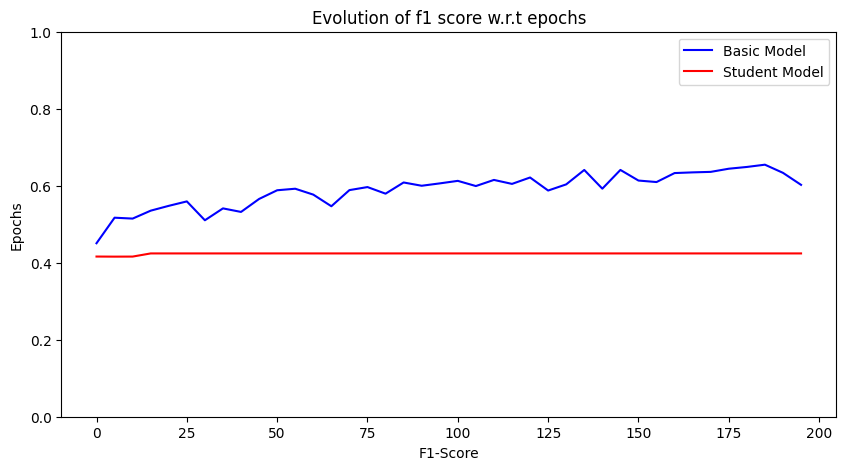

In [14]:
score_test = evaluate(student_model, loss_fcn, device, test_dataloader)
print("Student Model : F1-Score on the test set: {:.4f}".format(score_test))


def plot_f1_score(epoch_list, basic_model_scores, student_model_scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, basic_model_scores, "b", label="Basic Model")
    plt.plot(epoch_list, student_model_scores, "r", label="Student Model")
    plt.title("Evolution of f1 score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.ylabel("Epochs")
    plt.xlabel("F1-Score")
    plt.legend()
    plt.show()


plot_f1_score(epoch_list, basic_model_scores, student_model_scores)

## **PART 2 : QUESTIONS** (12/20)

**1. Make a small paragraph that : (4pts)**
1. Explains your achitecture and justify your choices (why the Graph Layer you chose is more efficient than the GCNLayer from the Basic Model?).
2. Analyses your results (what is the F1-Score ? are your results convincing ? what is your position w.r.t state-of-the-art ?).

In [15]:
# Your code goes here

>Answer

**2. Provide a diagramm of your architecture, which includes a good and clear legend as well as shapes information. The diagramm must be submitted as an external file, along with this notebook (PDF, JEPG or PNG format accepted). (2pts)**

**3. Make a small paragraph that explains: (6pts)**
1. What _oversmoothing_ is in the context of Graph Neural Network. Why is it an issue ? 
2. Are there solutions to overcome it ? 
3. Do you think the model you constructed is robust with respect to oversmoothing ? Why ?

> Answer